# Using the Entire Dataset

In the last Step, we saw how Logistic Regression fared in predicting the 2022 tournament using the 2022 regular season data. How will it do against history? What if we instead use every single regular season data to predict the 2022 tournament? Will it be better or worse? We will answer all those questions here.

## Data Preparation and Feature Selection

But first, let us copy our prep code.

In [282]:
import pandas as pd
import numpy as np
import collections

In [283]:
# Regular Season Results since 1985 (Only includes who won and the points)
reg_season_compact_pd = pd.read_csv('Data/MRegularSeasonCompactResults.csv') \

# Regular Season Results since 2003 but includes useful stats like Rebounds, Assists, etc.
reg_season_detailed_pd = pd.read_csv('Data/MRegularSeasonDetailedResults.csv')

# List of teams who are/was in Division I along with their ID
teams_pd = pd.read_csv('Data/MTeams.csv')

# Like the first two DataFrames but for the tournament
tourney_compact_pd = pd.read_csv('Data/MNCAATourneyCompactResults.csv')
tourney_detailed_pd = pd.read_csv('Data/MNCAATourneyDetailedResults.csv')

# The Conference Tourney Detailed Results since 2003
conference_tourney_results_pd = pd.read_csv('Data/MConferenceTourneyGames.csv')

# List of Teams along with their Conferences and ID per Year
conferences_pd = pd.read_csv('Data/MTeamConferences.csv')

# Seeds 
seeds_pd = pd.read_csv('Data/MNCAATourneySeeds.csv')

# List of Conference Tourney Winners since 2001
l = []
for i in range(len(conference_tourney_results_pd) - 1):
    if conference_tourney_results_pd.iloc[i, 1] != conference_tourney_results_pd.iloc[i + 1, 1]:
        season = conference_tourney_results_pd.iloc[i, 0]
        conference = conference_tourney_results_pd.iloc[i, 1]
        winner = conference_tourney_results_pd.iloc[i, 3]
        l.append({'Season': season, 'Conference': conference, 'Winner': winner})
        
conference_tourney_winners_pd = pd.DataFrame(l)

Now before we proceed, we have to do some small cleaning first. Every round except the last round lasts 2 days where half of the games are played on one day and the other half are played the next. In the case of the first round, we have 16 games played on each of the two days..., except for one. 

In 2021, 10 seeded VCU had to forefit due to COVID protocols making 7 seeded Oregon advance automatically. We can find it over here.

In [284]:
c1 = tourney_compact_pd['Season'] == 2021
c2 = tourney_compact_pd['DayNum'] == 138
print(len(tourney_compact_pd[c1 & c2]))
tourney_compact_pd[c1 & c2]

15


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2271,2021,138,1101,53,1400,52,N,0
2272,2021,138,1104,68,1233,55,N,0
2273,2021,138,1160,96,1207,73,N,0
2274,2021,138,1166,63,1364,62,N,0
2275,2021,138,1199,64,1422,54,N,0
2276,2021,138,1211,98,1313,55,N,0
2277,2021,138,1234,86,1213,74,N,0
2278,2021,138,1242,93,1186,84,N,0
2279,2021,138,1261,76,1382,61,N,0
2280,2021,138,1268,63,1163,54,N,0


To fix this, we can simply add in a new row and reset the index like so. We must enter the year to 2021, day number to 138, winning team id to Oregon's ID (1332), losing team id to VCU's ID (1433), and win location which will be set to neutral. As for the scores and number of overtime, we could make it up (of course with WScore > LScore). We will only do this for the compact results since we have no use for the detailed one.

In [285]:
# Create the new row
tourney_compact_pd.loc[len(tourney_compact_pd)] = [2021, 138, 1332, 64, 1433, 59, 'N', 0]

# Re-index it
tourney_compact_pd = tourney_compact_pd.sort_values(['Season', 'DayNum', 'WTeamID']).reset_index()

# Delete that pesky index column
tourney_compact_pd = tourney_compact_pd.drop(columns = ['index'])

c1 = tourney_compact_pd['Season'] == 2021
c2 = tourney_compact_pd['DayNum'] == 138
tourney_compact_pd[c1 & c2]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2271,2021,138,1101,53,1400,52,N,0
2272,2021,138,1104,68,1233,55,N,0
2273,2021,138,1160,96,1207,73,N,0
2274,2021,138,1166,63,1364,62,N,0
2275,2021,138,1199,64,1422,54,N,0
2276,2021,138,1211,98,1313,55,N,0
2277,2021,138,1234,86,1213,74,N,0
2278,2021,138,1242,93,1186,84,N,0
2279,2021,138,1261,76,1382,61,N,0
2280,2021,138,1268,63,1163,54,N,0


Now we proceed like normal. Preparing our functions...

In [286]:
# Get ID given Name
def getTeamID(name):
    return teams_pd[teams_pd['TeamName'] == name].values[0][0]

# Get Name given ID
def getTeamName(team_id):
    return teams_pd[teams_pd['TeamID'] == team_id].values[0][1]

In [287]:
# How many wins did a Team win in a given Season
def getRegSeasonWins(team_id, year):
    c1 = reg_season_compact_pd['WTeamID'] == team_id
    c2 = reg_season_compact_pd['Season'] == year
    return len(reg_season_compact_pd[c1 & c2])

# What was a team's Points per Game in a given Season
def getPPG(team_id, year):
    ppg = 0
    c1 = reg_season_compact_pd['WTeamID'] == team_id
    c2 = reg_season_compact_pd['Season'] == year
    c3 = reg_season_compact_pd['LTeamID'] == team_id
    gamesWon = reg_season_compact_pd[c1 & c2]
    ppg = gamesWon['WScore'].sum()
    gamesLost = reg_season_compact_pd[c2 & c3]
    ppg += gamesLost['LScore'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    ppg /= total_games
    return round(ppg, 2)

# In a given season, how many points did a given team give up per game
def getOPPG(team_id, year):
    oppg = 0
    c1 = reg_season_compact_pd['WTeamID'] == team_id
    c2 = reg_season_compact_pd['Season'] == year
    c3 = reg_season_compact_pd['LTeamID'] == team_id
    gamesWon = reg_season_compact_pd[c1 & c2]
    oppg = gamesWon['LScore'].sum()
    gamesLost = reg_season_compact_pd[c2 & c3]
    oppg += gamesLost['WScore'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    oppg /= total_games
    return round(oppg, 2)

Now we run into the problem where teams are constantly moving divisions which means that teams may be a Power 6 conference on some years and not on the others. Thankfully, we do not have to hardcode this anymore.

In [288]:
# Set conditions for Power 6 Conference
acc = conferences_pd['ConfAbbrev'] == 'acc'
big12 = conferences_pd['ConfAbbrev'] == 'big_twelve'
bigeast = conferences_pd['ConfAbbrev'] == 'big_east'
big10 = conferences_pd['ConfAbbrev'] == 'big_ten'
pac12 = conferences_pd['ConfAbbrev'] == 'pac_twelve'
sec = conferences_pd['ConfAbbrev'] == 'sec'

# Make Dataframe where it only contains Power 6 teams
p6 = conferences_pd[acc | big12 | bigeast | big10 | pac12 | sec]

def getPower6(team_id, year):
    # Filter out the Dataframe for the appropiate year
    c1 = conferences_pd['Season'] == year
    
    # Get the list of TeamID's that sufficies all the conditions
    p6_list = list(p6[c1]['TeamID'])

    return team_id in p6_list

In [289]:
# How many three's did a team make per game in a given season
def get3PT(team_id, year):
    if year < 2003:
        return 0
    threes = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    threes = gamesWon['WFGM3'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    threes += gamesLost['LFGM3'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    threes /= total_games
    return round(threes, 2)

# How many turnovers did a team make per game in a given season
def getTO(team_id, year):
    if year < 2003:
        return 0
    to = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    to = gamesWon['WTO'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    to += gamesLost['LTO'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    to /= total_games
    return round(to, 2)

In [290]:
# How many Assists did a team make per game
def getAST(team_id, year):
    if year < 2003:
        return 0
    ast = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    ast = gamesWon['WAst'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    ast += gamesLost['LAst'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    ast /= total_games
    return round(ast, 2)

# Determine if a team was the conference champion in their division in a given year
def getTourneyConferenceChampion(team_id, year):
    if year < 2001:
        return 0
    conf = getConference(team_id, year)
    c1 = conference_tourney_winners_pd['Season'] == year
    c2 = conference_tourney_winners_pd['Conference'] == conf
    if len(conference_tourney_winners_pd[c1 & c2]) == 0:
        return 0
    if team_id == conference_tourney_winners_pd[c1 & c2]['Winner'].values[0]:
        return 1
    else:
        return 0

In [291]:
# Easy way to get a team's conference in a given year
def getConference(team_id, year):
    c1 = conferences_pd['TeamID'] == team_id
    c2 = conferences_pd['Season'] == year
    c3 = conferences_pd[c1 & c2]
    if len(c3) == 0:
        return conferences_pd[c1].values[0][2]
    return c3['ConfAbbrev'].values[0]

# Get the seed of the team in a given year
def getSeed(team_id, year):
    c1 = seeds_pd['TeamID'] == team_id
    c2 = seeds_pd['Season'] == year
    if len(seeds_pd[c1 & c2]) == 0:
        return 0
    return int(seeds_pd[c1 & c2]['Seed'].values[0][1:3])

# Get rebounds per game in a given year
def getRPG(team_id, year):
    if year < 2003:
        return 0
    reb = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    reb = gamesWon['WOR'].sum()
    reb += gamesWon['WDR'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    reb += gamesLost['LOR'].sum()
    reb += gamesLost['LDR'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    reb /= total_games
    return round(reb, 2)

In [292]:
# Steals per game
def getSTL(team_id, year):
    if year < 2003:
        return 0
    stl = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    stl = gamesWon['WStl'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    stl += gamesLost['LStl'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    stl /= total_games
    return round(stl, 2)

# How many times did a team appear in the tournament as of 2022
def getNumOfAppearances(team_id):
    return len(seeds_pd[seeds_pd['TeamID'] == team_id])

# Helper function for below
def getHomeStat(row):
    if (row == 'H'):
        home = 1
    if (row == 'A'):
        home = -1
    if (row == 'N'):
        home = 0
    return home

In [293]:
# Build the vector
def getSeasonData(team_id, year):
    # Check first if the team was Division 1 at the time
    c1 = teams_pd[teams_pd['TeamID'] == team_id]['FirstD1Season'].values[0] <= year
    c2 = teams_pd[teams_pd['TeamID'] == team_id]['LastD1Season'].values[0] >= year
    if ~c1 or ~c2:
        return []
    return [getRegSeasonWins(team_id, year),
            getPPG(team_id, year),
            getOPPG(team_id, year),
            getPower6(team_id, year),
            get3PT(team_id, year),
            getTO(team_id, year),
            getAST(team_id, year),
            getTourneyConferenceChampion(team_id, year),
            getSeed(team_id, year),
            getRPG(team_id, year),
            getSTL(team_id, year),
            getNumOfAppearances(team_id)]

# Build vectors for every team in a given season
def createSeasonDict(year):
    seasonDictionary = collections.defaultdict(list)
    for team in teams_pd['TeamName'].tolist():
        team_id = teams_pd[teams_pd['TeamName'] == team].values[0][0]
        team_vector = getSeasonData(team_id, year)
        seasonDictionary[team_id] = team_vector
    return seasonDictionary

In [294]:
# Basically run the function directly above this one on a set of years
def createTrainingSet(years):
    totalNumGames = 0
    for year in years:
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        totalNumGames += len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        totalNumGames += len(tourney.index)
    numFeatures = len(getSeasonData(1181,2012)) #Just choosing a random team and seeing the dimensionality of the vector
    xTrain = np.zeros(( totalNumGames, numFeatures + 1))
    yTrain = np.zeros(( totalNumGames ))
    indexCounter = 0
    for year in years:
        team_vectors = createSeasonDict(year)
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        numGamesInSeason = len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        numGamesInSeason += len(tourney.index)
        xTrainSeason = np.zeros(( numGamesInSeason, numFeatures + 1))
        yTrainSeason = np.zeros(( numGamesInSeason ))
        counter = 0
        for index, row in season.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = getHomeStat(row['WLoc'])
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = 0 #All tournament games are neutral
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        xTrain[indexCounter:numGamesInSeason+indexCounter] = xTrainSeason
        yTrain[indexCounter:numGamesInSeason+indexCounter] = yTrainSeason
        indexCounter += numGamesInSeason
    return xTrain, yTrain

## In What Years did Logisitic Regression do Well?

We are now going to run on Logistic Regression on all the years using that years' regular season dataset as the training and validation sets. In other words, when we are predicting the 2005 tournament, we will only use the 2005 regular season data. Again, the process is the same as it was in the previous step. We will make a list of helper functions so the final cell will not be huge.

### Setup

In [295]:
# Get DataFrame of the Tourney Results for the given year
def getAppropiateTournamentDataFrame(year):
    tourney_year = tourney_compact_pd[tourney_compact_pd["Season"] == year]
    seeds_year = seeds_pd[seeds_pd["Season"] == year]
    
    return tourney_year, seeds_year

Unfortunately, dealing with the playin matches is more complicated here. Before 2001, there was no playin. Between 2001 and 2010, we had only 1 game. Afterwards, the tournament expanded to the current format (as of 2023) with 4 play in games also known as the "First Four". Even though the play in winner from 2001 to 2010 got destroyed by their next opponent, it should still be considered here.

In [296]:
# PlayIn Winners
def getPlayInWinners(df, year):
    playin = []
    
    if year < 2001:
        return playin
    elif year >= 2011:
        for i in range(4):
            playin.append(df.iloc[i, 2])
    else:
        playin.append(df.iloc[0, 2])
        
    return playin

In [297]:
# Helper function to swap
def swap_it(m, x1, x2):
    m[x1], m[x2] = m[x2], m[x1]
    return m

# Get First Round Matchups for that given year for 2011 and later
def getMatchupsPost2011(df, year, playin):
    matchups = []
    k = 0
    
    # We will have to find the playin winner from each quadrant
    for i in range(8):
        if len(df.iloc[16 - i, 1]) == 4:
            if df.iloc[16 - i, 2] not in playin:
                k = 1
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 2], 'Team2ID': df.iloc[16 - i - k, 2]})
       
    k = 0

    for i in range(17, 25):
        if len(df.iloc[50 - i, 1]) == 4:
            if df.iloc[50 - i, 2] not in playin:
                k = 1
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 2], 'Team2ID': df.iloc[50 - i - k, 2]})
    
    k = 0

    for i in range(34, 42):
        if len(df.iloc[84 - i, 1]) == 4:
            if df.iloc[84 - i, 2] not in playin:
                k = 1
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 2], 'Team2ID': df.iloc[84 - i - k, 2]})

    k = 0
    
    for i in range(51, 59):
        if len(df.iloc[118 - i, 1]) == 4:
            if df.iloc[118 - i, 2] not in playin:
                k = 1
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 2], 'Team2ID': df.iloc[118 - i - k, 2]})

    for i in range(0, 4):
        matchups = swap_it(matchups, 8 * i + 1, 8 * i + 7)
        matchups = swap_it(matchups, 8 * i + 2, 8 * i + 4)
        
    return matchups

In [298]:
# Get First Round Matchups for that given year for before 2001
def getMatchupsPre2001(df, year):
    matchups = []
    
    # Since there is no playin, we can generate our matchups easily
    for i in range(8):
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 2], 'Team2ID': df.iloc[15 - i, 2]})

    for i in range(16, 24):
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 2], 'Team2ID': df.iloc[47 - i, 2]})

    for i in range(32, 40):
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 2], 'Team2ID': df.iloc[79 - i, 2]})
    
    for i in range(48, 56):
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 2], 'Team2ID': df.iloc[101 - i, 2]})

    for i in range(0, 4):
        matchups = swap_it(matchups, 8 * i + 1, 8 * i + 7)
        matchups = swap_it(matchups, 8 * i + 2, 8 * i + 4)
        
    return matchups

# Get First Round Matchups for that given year for 2001 - 2010
def getMatchups2001_2010(df, year, playin):
    matchups = []
    
    # For this one, we first find the PlayIn game
    for i in range(len(df)):
        if len(df.iloc[64 - i, 1]) == 4:
            s = 64 - i
            break
    
    df = df.reset_index()
    # We will delete the row of the loser
    if df.iloc[s, 1] not in playin:
        df1 = df.drop(s).reset_index()
    else:
        df1 = df.drop(s - 1).reset_index()
        
    # Then we proceed like the above function
    for i in range(8):
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 3], 'Team2ID': df.iloc[15 - i, 3]})

    for i in range(16, 24):
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 3], 'Team2ID': df.iloc[47 - i, 3]})

    for i in range(32, 40):
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 3], 'Team2ID': df.iloc[79 - i, 3]})
    
    for i in range(48, 56):
        matchups.append({'Round': 1, 'Team1ID': df.iloc[i, 3], 'Team2ID': df.iloc[101 - i, 3]})

    for i in range(0, 4):
        matchups = swap_it(matchups, 8 * i + 1, 8 * i + 7)
        matchups = swap_it(matchups, 8 * i + 2, 8 * i + 4)
        
    return matchups

In [299]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create Logistic Regression Model and Train it. Return Model and Validation Accuracy Score
def getModel(xData, yData):
    X_train, X_val, y_train, y_val = train_test_split(xData, yData, test_size = .3, random_state = 12)
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred_val = lr.predict(X_val)
    val_acc = accuracy_score(y_val, y_pred_val)
    
    return lr, val_acc

# Function to predict probability that Team 1 wins
def predictOutcome(team_data1, team_data2, model):
    diff = [a - b for a, b in zip(team_data1, team_data2)]
    diff.append(0)
    return model.predict([diff])

In [300]:
# Now we predict the tournament given the year
def predictTheTournament(year, matchups, model):
    # These variables will be used to increment the round appropiately
    r = 2
    threshold = 32

    # store the odd team
    odd_team = 0

    for i in range(63):
        # First get the IDs
        team1 = matchups[i]['Team1ID']
        team2 = matchups[i]['Team2ID']
    
        # Then get their data
        t1_data = getSeasonData(team1, 2022)
        t2_data = getSeasonData(team2, 2022)
    
        # Get 0 or 1 value by running the above function
        prob = predictOutcome(t1_data, t2_data, model)
    
        # Predict team
        if prob: 
            matchups[i]['Predicted_Winner'] = team1
        else:
            matchups[i]['Predicted_Winner'] = team2
        
        # Add a new row to the matchups once two games are complete until we have 63 games
        if len(matchups) < 64:
            if i % 2 == 1:
                matchups.append({'Round': r, 'Team1ID': odd_team, 'Team2ID': matchups[i]['Predicted_Winner']})
                odd_team = 0
            else:
                odd_team = team1
            
        if i == threshold:
            threshold += (32 / 2**(r - 1))
            r += 1
            
    return matchups

In [301]:
# Get the Actual Winners for each round
def getActualWinners(df, year):
    #First we need to know when to start our indexing
    if year < 2001:
        offset = 0
    elif year >= 2011:
        offset = 4
    else:
        offset = 1
        
    actual_winners = []
    r1 = []
    r2 = []
    r3 = []
    r4 = []
    r5 = []
    r6 = []
    
    # Make Round 1 list
    for i in range(offset, 32 + offset):
        r1.append(df.iloc[i, 2])
    
    # Round 2
    for i in range(32 + offset, 48 + offset):
        r2.append(df.iloc[i, 2])   
    
    # Round 3
    for i in range(48 + offset, 56 + offset):
        r3.append(df.iloc[i, 2]) 
    
    # Round 4
    for i in range(56 + offset, 60 + offset):
        r4.append(df.iloc[i, 2]) 
    
    # Round 5
    for i in range(60 + offset, 62 + offset):
        r5.append(df.iloc[i, 2]) 
    
    # Round 6
    r6.append(df.iloc[62 + offset, 2]) 
    
    actual_winners.append(r1)
    actual_winners.append(r2)
    actual_winners.append(r3)
    actual_winners.append(r4)
    actual_winners.append(r5)
    actual_winners.append(r6)
    
    return actual_winners

In [302]:
# Are we correct?
def answers(true, pred):
    for i in range(len(pred)):
        predicted_winner = pred[i]['Predicted_Winner']
        r = pred[i]['Round']
        if predicted_winner in true[r - 1]:
            pred[i]['Correct'] = 1
        else:
            pred[i]['Correct'] = 0
            
    return pred

# Create DataFrame with the Predicted Winners and the Correct Column
def getResultsDataFrame(results, year):
    df = pd.DataFrame(results)
    df['Year'] = year
    return df

# How were the wins distributed by round?
def getRoundDist(df):
    correct_per_round = []
    for i in range(1, 7):
        c1 = df['Round'] == i
        cor = df['Correct'] == 1
        correct_per_round.append((i, len(df[c1 & cor])))
        
    return correct_per_round

def getDict(year, correct, round_dist, val_score):
    d = {}
    d['Year'] = year
    d['Correct'] = correct
    d['R1'] = round_dist[0][1]
    d['R2'] = round_dist[1][1]
    d['R3'] = round_dist[2][1]
    d['R4'] = round_dist[3][1]
    d['R5'] = round_dist[4][1]
    d['R6'] = round_dist[5][1]
    d['Correct %'] = round((correct / 63) * 100, 2)
    d['Val %'] =round(val_score * 100, 2)
    return d

In [304]:
import time
import warnings
warnings.filterwarnings('ignore')

# Create the years
years = [i for i in range(1985, 2023) if i != 2020]
year_results = []

start = time.time_ns()
for year in years:
    print("Running Year %d. Current Runtime: %f seconds." % (year, (time.time_ns() - start) / 1e9))
    # Create training/validation set
    xTrain, yTrain = createTrainingSet([year])
    
    # Get DataFrame of Tourney with the concerned year
    tourney_year, seeds_year = getAppropiateTournamentDataFrame(year)
    
    # Get PlayIn Winners
    playin = getPlayInWinners(tourney_year, year)
    
    # Generate matchups
    if year < 2001:
        matchups = getMatchupsPre2001(seeds_year, year)
    elif year >= 2011:
        matchups = getMatchupsPost2011(seeds_year, year, playin)
    else:
        matchups = getMatchups2001_2010(seeds_year, year, playin)
        
    # Get Trained model and Val Accuracy
    model, val_acc = getModel(xTrain, yTrain)
    
    # Get the Predicted Tournament Results
    results = predictTheTournament(year, matchups, model)
    
    # Get the actual results 
    actual_results = getActualWinners(tourney_year, year)
    
    # Append our Predicted Tournament Results the Correct column
    results = answers(actual_results, results)
    
    # Get our DataFrame containing the Predicted Results and the Correct column
    results_pd = getResultsDataFrame(results, year)
    
    # Get Number of correct predictions
    num_correct = len(results_pd[results_pd['Correct'] == 1])
    
    # Finally Get Round Distribution
    round_dist = getRoundDist(results_pd)
    
    # Let us also put our results in a year-by-year Dictionary and append to our year_results list
    year_results.append(getDict(year, num_correct, round_dist, val_acc))
    
print("Finished. Total Runtime: %f seconds." % ((time.time_ns() - start) / 1e9))

Running Year 1985. Current Runtime: 0.000153 seconds.
Running Year 1986. Current Runtime: 3.364792 seconds.
Running Year 1987. Current Runtime: 6.620215 seconds.
Running Year 1988. Current Runtime: 9.918848 seconds.
Running Year 1989. Current Runtime: 13.235941 seconds.
Running Year 1990. Current Runtime: 16.532520 seconds.
Running Year 1991. Current Runtime: 19.841704 seconds.
Running Year 1992. Current Runtime: 23.183362 seconds.
Running Year 1993. Current Runtime: 26.510732 seconds.
Running Year 1994. Current Runtime: 29.848937 seconds.
Running Year 1995. Current Runtime: 33.189792 seconds.
Running Year 1996. Current Runtime: 36.522393 seconds.
Running Year 1997. Current Runtime: 39.886502 seconds.
Running Year 1998. Current Runtime: 43.268961 seconds.
Running Year 1999. Current Runtime: 46.628340 seconds.
Running Year 2000. Current Runtime: 50.028800 seconds.
Running Year 2001. Current Runtime: 53.479689 seconds.
Running Year 2002. Current Runtime: 57.242901 seconds.
Running Year 2

### Year-by-Year Analyis

Now let us visualize how Logistic Regression fared. We will look at some of the data and see some possible trends or anomalies.

In [326]:
year_results_pd = pd.DataFrame(year_results)
year_results_pd.describe()

,Year,Correct,R1,R2,R3,R4,R5,R6,Correct %,Val %
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,2003.054054,34.594595,22.081081,8.027027,2.864865,1.081081,0.459459,0.081081,54.912162,75.262432
std,10.916211,3.818518,2.301912,1.554322,1.134366,0.795067,0.557504,0.276725,6.060470,0.963141
min,1985.000000,26.000000,18.000000,5.000000,0.000000,0.000000,0.000000,0.000000,41.270000,73.600000
25%,1994.000000,32.000000,20.000000,7.000000,2.000000,1.000000,0.000000,0.000000,50.790000,74.470000
50%,2003.000000,35.000000,22.000000,8.000000,3.000000,1.000000,0.000000,0.000000,55.560000,75.150000
75%,2012.000000,37.000000,24.000000,10.000000,3.000000,2.000000,1.000000,0.000000,58.730000,75.970000
max,2022.000000,43.000000,27.000000,10.000000,6.000000,3.000000,2.000000,1.000000,68.250000,77.270000


So a lot to unpack here; at a quick glance, we seem to have no outliers using both measures of spread. Well, let us answer if Logistic Regression fares over the years.

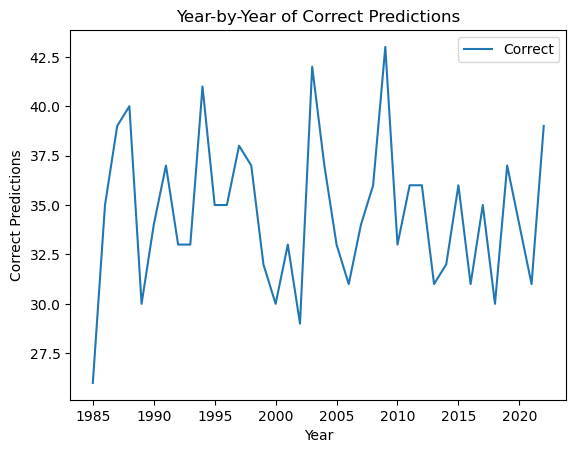

In [316]:
import matplotlib.pyplot as plt

year_results_pd.plot(x = 'Year', y = 'Correct', kind = 'line')
plt.ylabel("Correct Predictions")
plt.title("Year-by-Year of Correct Predictions")
plt.show()

So Logistic Regression is more up and down since we do not see any real pattern in this bar graph. What we do knwo is that 2009 had the most correct observations while 1985 had the least. 2017 had around average correct. Let us view these three years more in detail.

In [315]:
c1 = year_results_pd['Year'] == 1985
c2 = year_results_pd['Year'] == 2009
c3 = year_results_pd['Year'] == 2017

year_results_pd[c1 | c2 | c3]

,Year,Correct,R1,R2,R3,R4,R5,R6,Correct %,Val %
0,1985,26,20,5,1,0,0,0,41.27,73.95
24,2009,43,27,10,3,2,1,0,68.25,74.40
32,2017,35,24,8,3,0,0,0,55.56,74.07


Well, when you do not get a lot of correct in the first round, you give yourself few outs in the following rounds, and before you know it, you got no chance. Conversely, if you get 27 correct out of 32 in the first round, you have much more chances to get more correct, and eventually predict the winner. But is that always the case? If the model correctly predicted the winner, how was its performance in the previous rounds?

In [325]:
year_results_pd.sort_values(['R6', 'Correct'], ascending = [False, False]).head(13)

,Year,Correct,R1,R2,R3,R4,R5,R6,Correct %,Val %
27,2012,36,21,8,3,1,2,1,57.14,75.69
16,2001,33,19,8,2,2,1,1,52.38,75.37
35,2021,31,21,5,2,1,1,1,49.21,74.34
24,2009,43,27,10,3,2,1,0,68.25,74.40
18,2003,42,27,10,5,0,0,0,66.67,75.00
9,1994,41,24,10,3,3,1,0,65.08,75.99
3,1988,40,25,10,3,2,0,0,63.49,75.70
2,1987,39,26,10,2,1,0,0,61.90,75.29
36,2022,39,24,9,4,2,0,0,61.90,74.32
12,1997,38,22,10,3,2,1,0,60.32,73.62


Interesting. Out of 38 tournaments, the Model predicted the winner correctly 3 times, but the accuracies of those three years are not even in the top 10 of correct predictions. In fact, we have one year (2021) where the model had more incorrect predictions but still managed to predict the winner. Weird.

Instead of predicting the winner, how well did the model predict the final four. According to the `describe()` method, we get on average 1 correct prediction. Well, let us see the histogram.

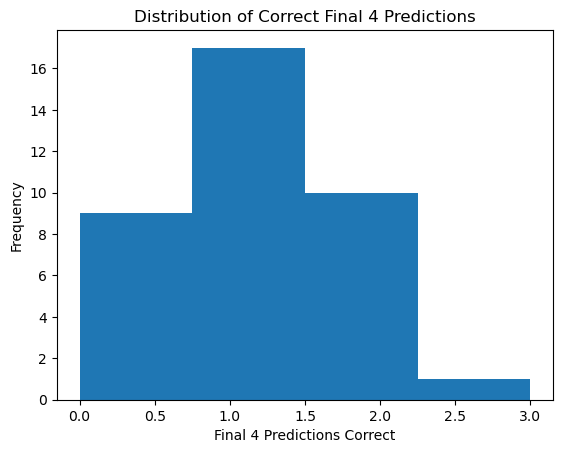

In [333]:
plt.hist(year_results_pd['R4'], bins = 4)
plt.xlabel("Final 4 Predictions Correct")
plt.ylabel("Frequency")
plt.title("Distribution of Correct Final 4 Predictions")
plt.show()

Well, predicting the winner of each quadrant is not easy, so you could say getting 1 correct on average is pretty good.

Finally, let us look at how the cross-val score affects the number of correct predictions. We saw that with thousands of samples, we get little variability, but it does not explain why Logistic Regression cannot consistently get 75% correct on the tournament.

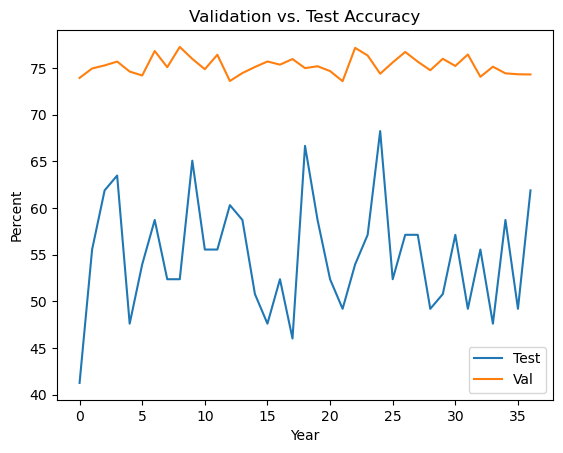

In [347]:
plt.plot(year_results_pd['Correct %'], label = 'Test')
plt.plot(year_results_pd['Val %'], label = 'Val')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.title('Validation vs. Test Accuracy')
plt.legend()
plt.show()

## Don't Worry We Scale!

In the previous section, we saw how Logistic Regression fared over the years where the **Training Data** was that year's data. In this section, we will use the entire regular season to predict the tournament. In other words, when predicting the 2005 tournament, we will use all regular season games from 1985-2005 as our training set. Scaling! 

### Setup

The code is mostly the same from last time. We simply just change one line of code.

In [349]:
warnings.filterwarnings('ignore')

# Create the years
years = [i for i in range(1985, 2023) if i != 2020]
year_results_totality = []

start = time.time_ns()
for year in years:
    print("Running Year %d. Current Runtime: %f seconds." % (year, (time.time_ns() - start) / 1e9))
    # Create training/validation set
    xTrain, yTrain = createTrainingSet([i for i in range(1985, year + 1)]) # WE CHANGE THIS LINE HERE
    
    # Get DataFrame of Tourney with the concerned year
    tourney_year, seeds_year = getAppropiateTournamentDataFrame(year)
    
    # Get PlayIn Winners
    playin = getPlayInWinners(tourney_year, year)
    
    # Generate matchups
    if year < 2001:
        matchups = getMatchupsPre2001(seeds_year, year)
    elif year >= 2011:
        matchups = getMatchupsPost2011(seeds_year, year, playin)
    else:
        matchups = getMatchups2001_2010(seeds_year, year, playin)
        
    # Get Trained model and Val Accuracy
    model, val_acc = getModel(xTrain, yTrain)
    
    # Get the Predicted Tournament Results
    results = predictTheTournament(year, matchups, model)
    
    # Get the actual results 
    actual_results = getActualWinners(tourney_year, year)
    
    # Append our Predicted Tournament Results the Correct column
    results = answers(actual_results, results)
    
    # Get our DataFrame containing the Predicted Results and the Correct column
    results_pd = getResultsDataFrame(results, year)
    
    # Get Number of correct predictions
    num_correct = len(results_pd[results_pd['Correct'] == 1])
    
    # Finally Get Round Distribution
    round_dist = getRoundDist(results_pd)
    
    # Let us also put our results in a year-by-year Dictionary and append to our year_results list
    year_results_totality.append(getDict(year, num_correct, round_dist, val_acc))
    
print("Finished. Total Runtime: %f seconds." % ((time.time_ns() - start) / 1e9))

Running Year 1985. Current Runtime: 0.000162 seconds.
Running Year 1986. Current Runtime: 3.512471 seconds.
Running Year 1987. Current Runtime: 8.894880 seconds.
Running Year 1988. Current Runtime: 15.953853 seconds.
Running Year 1989. Current Runtime: 24.798301 seconds.
Running Year 1990. Current Runtime: 35.421932 seconds.
Running Year 1991. Current Runtime: 47.853109 seconds.
Running Year 1992. Current Runtime: 62.276437 seconds.
Running Year 1993. Current Runtime: 78.552627 seconds.
Running Year 1994. Current Runtime: 96.213063 seconds.
Running Year 1995. Current Runtime: 115.712432 seconds.
Running Year 1996. Current Runtime: 137.019289 seconds.
Running Year 1997. Current Runtime: 161.764259 seconds.
Running Year 1998. Current Runtime: 187.315507 seconds.
Running Year 1999. Current Runtime: 214.886635 seconds.
Running Year 2000. Current Runtime: 244.290210 seconds.
Running Year 2001. Current Runtime: 275.826017 seconds.
Running Year 2002. Current Runtime: 309.756856 seconds.
Runni

30 minutes to run. Woof.

### Analysis

For this section, we will just focus on this DataFrame.

In [351]:
year_results_totality_pd = pd.DataFrame(year_results_totality)
year_results_totality_pd.describe()

,Year,Correct,R1,R2,R3,R4,R5,R6,Correct %,Val %
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,2003.054054,34.513514,22.081081,8.000000,2.837838,1.054054,0.432432,0.108108,54.782973,75.211351
std,10.916211,3.920187,2.228332,1.615893,1.258604,0.814656,0.554804,0.314800,6.222659,0.404998
min,1985.000000,26.000000,18.000000,4.000000,0.000000,0.000000,0.000000,0.000000,41.270000,73.950000
25%,1994.000000,32.000000,21.000000,7.000000,2.000000,0.000000,0.000000,0.000000,50.790000,75.090000
50%,2003.000000,34.000000,22.000000,8.000000,3.000000,1.000000,0.000000,0.000000,53.970000,75.250000
75%,2012.000000,37.000000,23.000000,9.000000,3.000000,2.000000,1.000000,0.000000,58.730000,75.390000
max,2022.000000,42.000000,27.000000,10.000000,7.000000,3.000000,2.000000,1.000000,66.670000,76.110000


No outliers, very similar validation scores, and an average correct prediction rate. How about over the years?

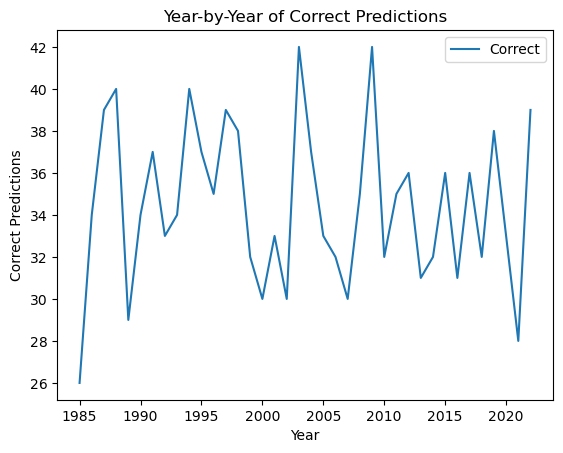

In [353]:
year_results_totality_pd.plot(x = 'Year', y = 'Correct', kind = 'line')
plt.ylabel("Correct Predictions")
plt.title("Year-by-Year of Correct Predictions")
plt.show()

Again, we see no clear pattern here, but rather we see up and down. Onto the Final 4 Predictive Accuracy.

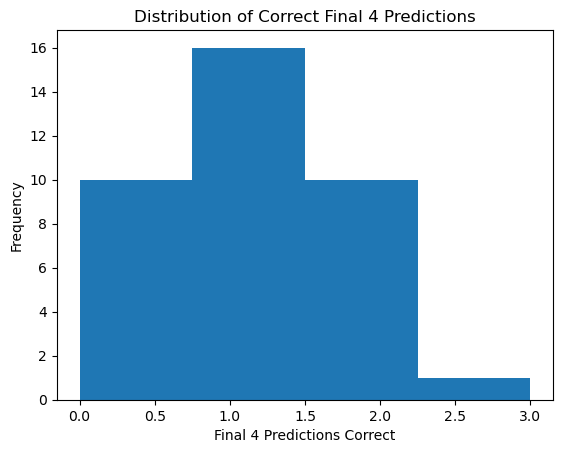

In [354]:
plt.hist(year_results_totality_pd['R4'], bins = 4)
plt.xlabel("Final 4 Predictions Correct")
plt.ylabel("Frequency")
plt.title("Distribution of Correct Final 4 Predictions")
plt.show()

Predicting only 1 correct on average is not a good sign, or are we just simply zeroing in on the actual average? 

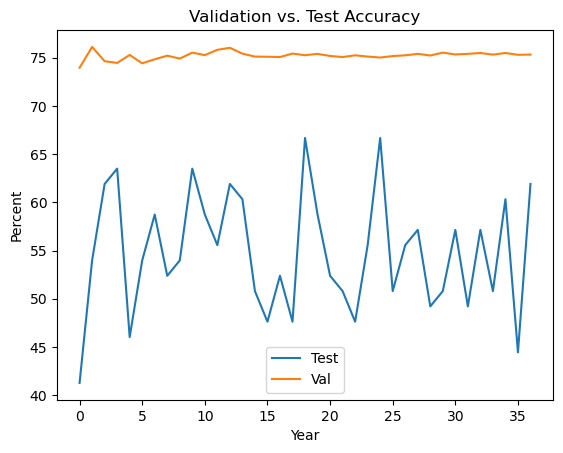

In [356]:
plt.plot(year_results_totality_pd['Correct %'], label = 'Test')
plt.plot(year_results_totality_pd['Val %'], label = 'Val')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.title('Validation vs. Test Accuracy')
plt.legend()
plt.show()

## Comparing the Two and Conclusions

So let us now compare the two and see which one is better. First, let us compare line plots.

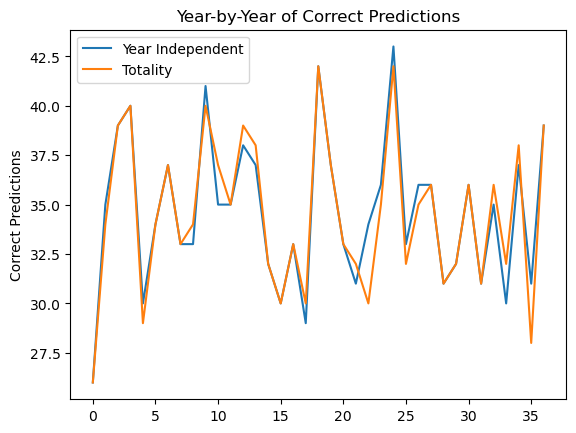

In [360]:
plt.plot(year_results_pd['Correct'], label = 'Year Independent')
plt.plot(year_results_totality_pd['Correct'], label = 'Totality')
plt.ylabel("Correct Predictions")
plt.title("Year-by-Year of Correct Predictions")
plt.legend()
plt.show()

So there is actually little difference between the independent and totality. Seems like doing the totality would be a waste of time.

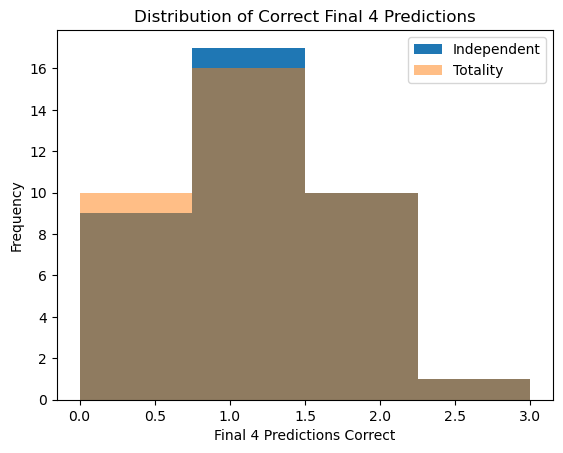

In [369]:
plt.hist(year_results_pd['R4'], bins = 4, label = 'Independent')
plt.hist(year_results_totality_pd['R4'], bins = 4, label = 'Totality', alpha = .5)
plt.xlabel("Final 4 Predictions Correct")
plt.ylabel("Frequency")
plt.title("Distribution of Correct Final 4 Predictions")
plt.legend()
plt.show()

So they only differ by 1! Also we seem to have only one year where there were three correct Final 4 predictions. Let us see if they are the same year or not.

In [377]:
print(year_results_pd[year_results_pd['R4'] == 3]['Year'])
year_results_totality_pd[year_results_totality_pd['R4'] == 3]['Year']

9    1994
Name: Year, dtype: int64


9    1994
Name: Year, dtype: int64

And they are the same. Two more plots; first we look at validation scores.

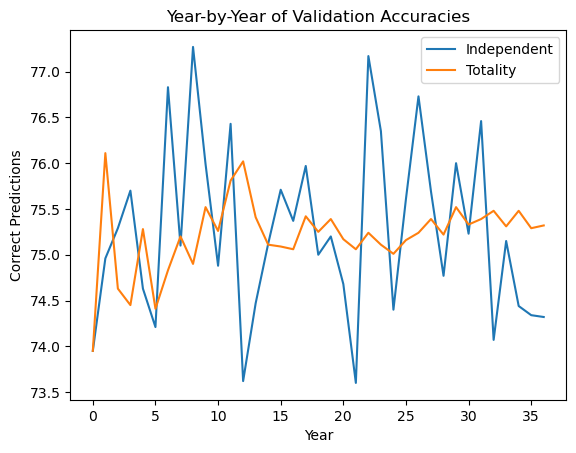

In [384]:
plt.plot(year_results_pd['Val %'], label = 'Independent')
plt.plot(year_results_totality_pd['Val %'], label = 'Totality')
plt.ylabel("Correct Predictions")
plt.title("Year-by-Year of Validation Accuracies")
plt.xlabel("Year")
plt.legend()
plt.show()

This is a little weird and here is why. For the Independent line plot, we have on average 5000 observations. With 30% being the validation set, that leads 1500 to be evaluated. Now 5000 is more than enough to see a graph "approach" a value, but we see varying percentages. On the other hand, the Totality plot seems to follow this calculus "limit" approach to the value of around 75.25 percent. Anyways, onwards to the last plot, the tournament set.

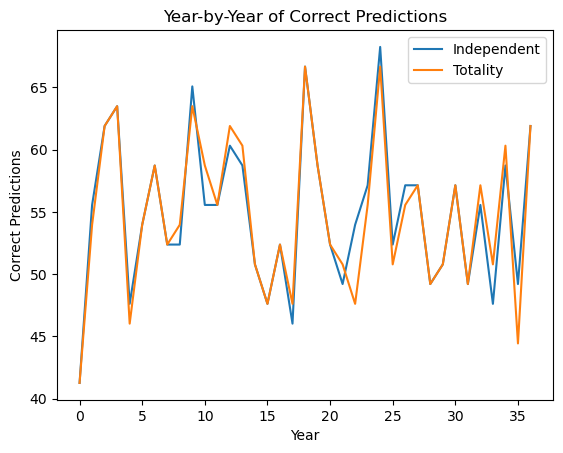

In [385]:
plt.plot(year_results_pd['Correct %'], label = 'Independent')
plt.plot(year_results_totality_pd['Correct %'], label = 'Totality')
plt.ylabel("Correct Predictions")
plt.title("Year-by-Year of Correct Predictions")
plt.xlabel("Year")
plt.legend()
plt.show()

So more of the same...

In conclusion, the only reasons why we should even consider using over 100,000 observations to train our model and to predict the 2023 tournament is because we either want to show that this type of problem can be scaled, or we like to toture our Intel-i5 processor dual core. Let us stick to the year-by-year training set instead.